# Landau levels for a simple square lattice and Graphene

## Import statments

In [25]:
import kwant
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tinyarray

## Helping functions

In [27]:
def hopping_by_hand(Site1, Site2, t, B):
    return -t * peierls(Site1, Site2, B)

def peierls(Site1, Site2, B):
    (x_i, y_i) = Site1.pos       # Target
    (x_j, y_j) = Site2.pos       # Source
    theta = -B/2 * (x_i - x_j) * (y_i + y_j)
    return np.exp(2j*np.pi*theta)

## Square lattice system

In [28]:
def square_lattice_lead(a_lattice, W, V=0):
    lat = kwant.lattice.square(a = a_lattice)
    sym = kwant.TranslationalSymmetry(lat.vec((-1,0)))
    syst = kwant.Builder(sym)
    syst[lat.shape(lambda s: 0 <= s[1] <= W, (0,0))] = V
    syst[lat.neighbors()] = hopping_by_hand
    return syst

In [29]:
syst_sqrd = square_lattice_lead(a_lattice=1, W=100, V=4)

In [30]:
# kwant.plot(syst_sqrd);

In [31]:
# kwant.plotter.bands(syst_sqrd.finalized(), params=dict(B=.5,t=1));

In [32]:
magnetic_field_values_sqr = np.linspace(0, 1, 200) # units of ϕ_0

In [33]:
energies_sqr = []
for B in magnetic_field_values_sqr:
    bands = kwant.physics.Bands(syst_sqrd.finalized(), params=dict(B=B, t=1))
    energies_sqr.append(bands(0))

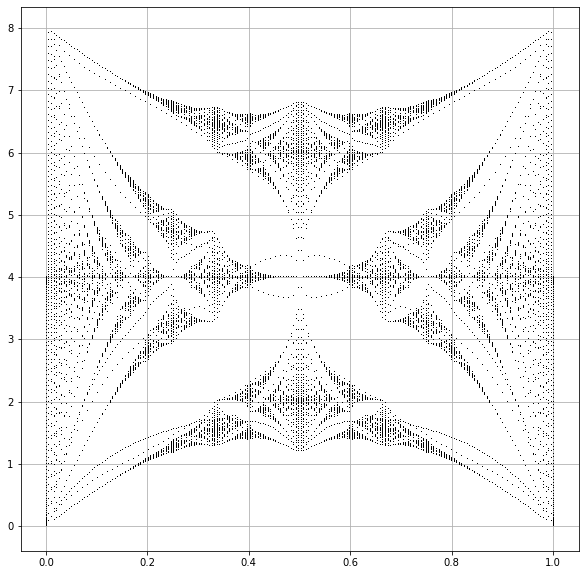

In [34]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(magnetic_field_values_sqr, energies_sqr, ',', c='k')
# ax.set_ylim(0,1)
# ax.set_xlim(0,0.1)
ax.grid()

In [35]:
# sites = [s for s in syst_sqrd.sites()]

In [36]:
# tags = [s.tag for s in sites]

In [37]:
# tags

## Zigzag Graphene nanoribbon

In [38]:
g_Lande = 2
Magneton_Bohr = 5.788e-5 # eV/T


zeros_2x2 = tinyarray.array([[0,0],[0,0]])
sigma_0 = tinyarray.array([[1,0],[0,1]])
sigma_x = tinyarray.array([[0,1],[1,0]])
sigma_y = tinyarray.array([[0,-1j],[1j,0]])
sigma_z = tinyarray.array([[1,0],[0,-1]])

In [39]:
class LeadShape:
    def __init__(self, W):
        self.W = W
    def __call__(self, pos):
        y = pos[1]
        return 0 < y <= self.W

    
def on_site_with_Zeeman(site, V, B):
    """
    This function defines the on-site energy by
    allowing to pass functions of position for
    the electrical potential and the magnetic field
    separately in order to account for the Zeeman
    effect.
    """
    x, y = site.pos
    H_Z = g_Lande * Magneton_Bohr/2 * B * sigma_z
    return V * sigma_0 + H_Z

    
def W_to_close(W):
    N = max(W // np.sqrt(3), 2)
    return N * np.sqrt(3), int(N)


def hopping_by_hand_with_spin(Site1, Site2, t, B):
    return -t * sigma_0 * peierls(Site1, Site2, B)


def graphene_lead(W):
    W_new, N = W_to_close(W)
    lead_shape = LeadShape(W_new)
    
    lat = kwant.lattice.honeycomb(a=1)
    
    symmetry = kwant.TranslationalSymmetry((-1,0))
    symmetry.add_site_family(lat.sublattices[0], other_vectors=[(-1,2)])
    symmetry.add_site_family(lat.sublattices[1], other_vectors=[(-1,2)])
    
    lead = kwant.Builder(symmetry)
    lead[lat.shape(lead_shape, (0,0))] = on_site_with_Zeeman
    lead[lat.neighbors()] = hopping_by_hand_with_spin
    
    return lead

In [40]:
g_lead = graphene_lead(W=50)

In [41]:
# kwant.plotter.bands(g_lead.finalized(), params=dict(t=1,B=0,V=0));

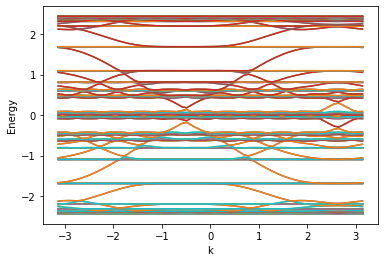

In [42]:
kwant.plotter.bands(g_lead.finalized(), params=dict(t=1, B=2*np.pi*0.1, V=0));

In [52]:
Npts = 401
magnetic_flux_graphene = np.linspace(0, 1, Npts)
energies_graphene = []

for Bflux in magnetic_flux_graphene:
    Bfield = Bflux / (np.sqrt(3)/2)
    bands = kwant.physics.Bands(g_lead.finalized(), params=dict(t=1, B=Bfield, V=0))
    energies_graphene.append(bands(0))

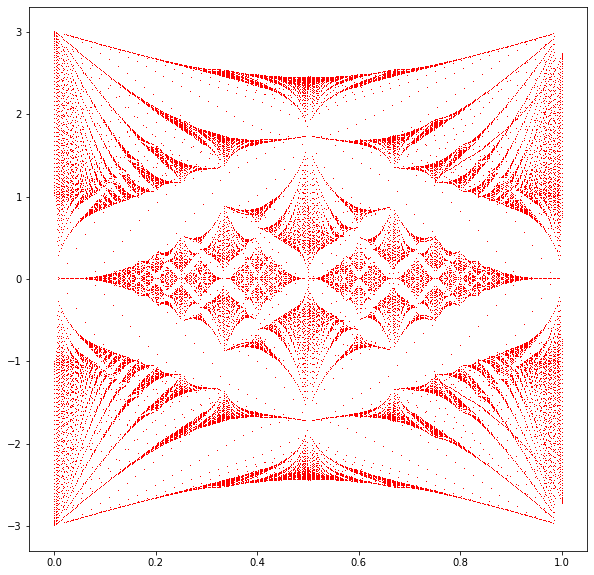

In [54]:
plt.figure(figsize=(10,10))
plt.plot(magnetic_flux_graphene, energies_graphene, ',', c='r');
# plt.xlim(0, 2.3 * np.pi)
# plt.ylim(-1,1)

## Using `kwant.physics.magnetic_gauge`

In [44]:
class Rectangle:
    def __init__(self, W, L):
        self.W = W
        self.L = L
    def __call__(self, pos):
        """
        Define the scattering region's shape.
        """
        W, L = self.W, self.L
        x, y = pos
        return 0 < y <= W and 0 <= x < L

In [72]:
def hopping_gauge(site1, site2, t, peierls):
    return -t * sigma_0 * peierls(site1, site2)

In [73]:
def on_site(site, V):
    """
    Simple onsite energy for a 2-orbital site.
    """
    x, y = site.pos
    return V * sigma_0

In [86]:
## Global:
lat = kwant.lattice.honeycomb(a=1, norbs=2)

def make_graphene_strip_gauge(hopping, W, L):
    # DEFINING THE SYSTEM'S SHAPE
    W_new, N = W_to_close(W)
    rectangle = Rectangle(W_new, L)

    syst = kwant.Builder()
    syst[lat.shape(rectangle, (0, 0))] = on_site
    syst[lat.neighbors()] = hopping

    return syst

def graphene_lead_gauge(hopping, W):
    W_new, N = W_to_close(W)
    lead_shape = LeadShape(W_new)
    
    symmetry = kwant.TranslationalSymmetry((-1,0))
#     symmetry.add_site_family(lat.sublattices[0], other_vectors=[(-1,2)])
#     symmetry.add_site_family(lat.sublattices[1], other_vectors=[(-1,2)])
    
    lead = kwant.Builder(symmetry)
    lead[lat.shape(lead_shape, (0,0))] = on_site
    lead[lat.neighbors()] = hopping
    
    return lead

In [104]:
syst_gauge = make_graphene_strip_gauge(hopping_gauge, W=20, L=20)
lead_gauge = graphene_lead_gauge(hopping_gauge, W=20)
lead_gauge.substituted(peierls='peierls_lead');

syst_gauge.attach_lead(lead_gauge)
fsyst_gauge = syst_gauge.finalized()

In [105]:
# fsyst_gauge = lead_gauge.finalized()

In [106]:
gauge = kwant.physics.magnetic_gauge(fsyst_gauge)

In [107]:
peierls_syst, peierls_lead = gauge(0.5, 0.0)

In [108]:
type(peierls_gauge)

functools.partial

In [109]:
parameters = dict(peierls=peierls_syst, 
                  peierls_lead=peierls_lead, 
                  t=1, 
                  V=0)

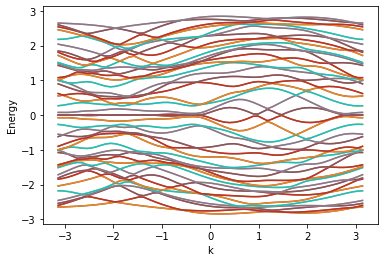

In [110]:
kwant.plotter.bands(fsyst_gauge.leads[0], params=parameters);

In [60]:
sites_lead_gauge = [s for s in lead_gauge.sites()]

In [61]:
len(sites_lead_gauge)

460

In [62]:
sites_lead_gauge[0]

Site(kwant.lattice.Monatomic([[1.0, 0.0], [0.5, 0.8660254037844386]], [0.0, 0.5773502691896258], '1', 2), array([0, 0]))

In [98]:
magnetic_field_gauge_values = 2*np.pi * np.linspace(0, 0.2, 201)

energies_graphene_gauge = []

for Bfield in magnetic_field_values_graphene:
    peierls_syst, peierls_lead = gauge(Bfield, Bfield)
    bands = kwant.physics.Bands(fsyst_gauge.leads[0], params=parameters)
    energies_graphene_gauge.append(bands(0))

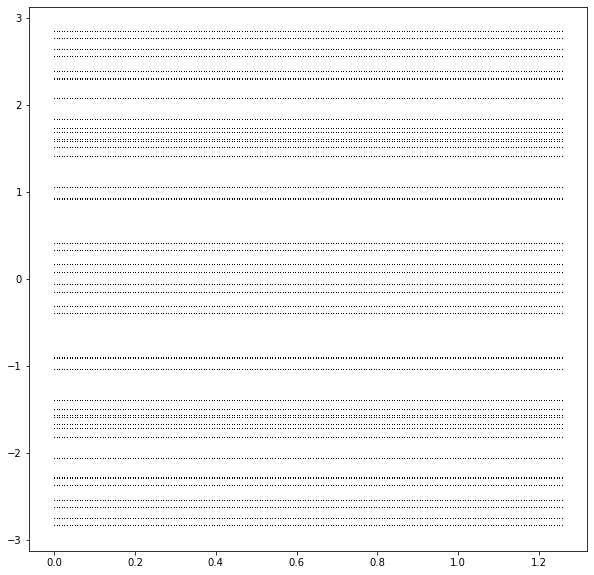

In [99]:
plt.figure(figsize=(10,10))
plt.plot(magnetic_field_gauge_values, energies_graphene_gauge, ',', c='k');
# plt.xlim(0,0.2)
# plt.ylim(-1,1)

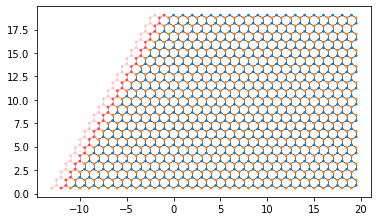

In [113]:
kwant.plot(syst_gauge);